In [7]:
import gymnasium as gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from stable_baselines3 import PPO
from stable_baselines3 import DQN
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy

from envs.mimic import MIMICEnv
from dddqn import DDDQN_Agent

In [2]:
env = MIMICEnv()


def eval_policy(model, env, n_episodes=20, verbose=True):
    """ Custom evaluation for stable baselines policies """

    returns, lengths = evaluate_policy(model, env, n_eval_episodes=n_episodes, return_episode_rewards=True)

    if verbose:
        fig, (ax1, ax2) = plt.subplots(1, 2)
        ax1.set_title('return / episode')
        ax1.plot(returns)
        ax2.set_title('episode length')
        ax2.plot(lengths)
        plt.show()

        print(f'avg return: {np.mean(returns)}, avg episode length: {np.mean(lengths)}')

    else:
        return np.mean(returns), np.mean(lengths)

/Users/jakeweiss/miniconda3/envs/py39/lib/python3.9/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


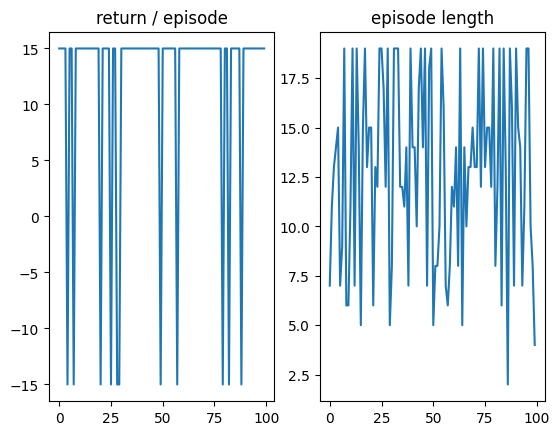

avg return: 11.7, avg episode length: 12.9


In [4]:
### Proximal Policy Optimization ###

ppo_model = PPO('MlpPolicy', env, verbose=False).learn(total_timesteps=5000)
#ppo_model.save('models/mimic_ppo')

#ppo_model = PPO.load('models/mimic_ppo')

eval_policy(ppo_model, env, n_episodes=100)

/Users/jakeweiss/miniconda3/envs/py39/lib/python3.9/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


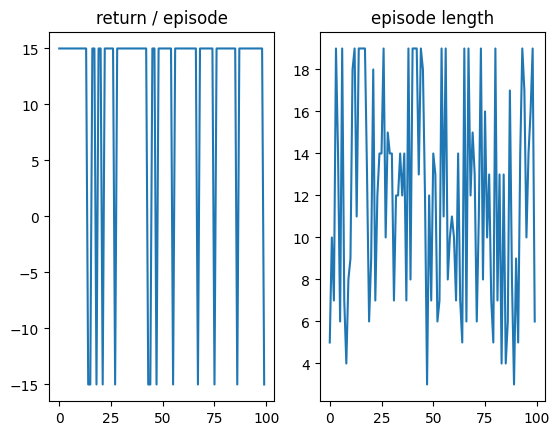

avg return: 11.1, avg episode length: 12.06


In [5]:
### Deep Q Networks ###

dqn_model = DQN('MlpPolicy', env, verbose=False).learn(total_timesteps=5000)
#dqn_model.save('models/mimic_dqn')

#dqn_model = DQN.load('models/mimic_dqn')

eval_policy(dqn_model, env, n_episodes=100)

In [27]:
### Dueling Double Deep Q Networks ###

n_epochs = 500
update_freq = 100

dddqn_agent = DDDQN_Agent(env.obs_dim, env.action_dim)
rewards = []
episode_lengths = []

# train
for epoch in tqdm(range(n_epochs)):
    done = False
    total_reward = 0
    episode_length = 0
    state, _ = env.reset()
    
    while not done:
        action = dddqn_agent.select_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        dddqn_agent.learn(state, action, reward, next_state, done)
        #print(f'epoch #{epoch}, {done=}, {env.patient.index=}')
        
        done = terminated or truncated
        state = next_state
        total_reward += reward
        episode_length += 1

    rewards.append(total_reward)
    episode_lengths.append(episode_length)

    if epoch % update_freq == 0:
        dddqn_agent.hard_update()


train_df = pd.DataFrame({'rewards': rewards, 'episode_lengths': episode_lengths})


100%|████████████████████████████████████████| 500/500 [00:04<00:00, 103.58it/s]


Text(0.5, 1.0, 'dddqn episode lengths')

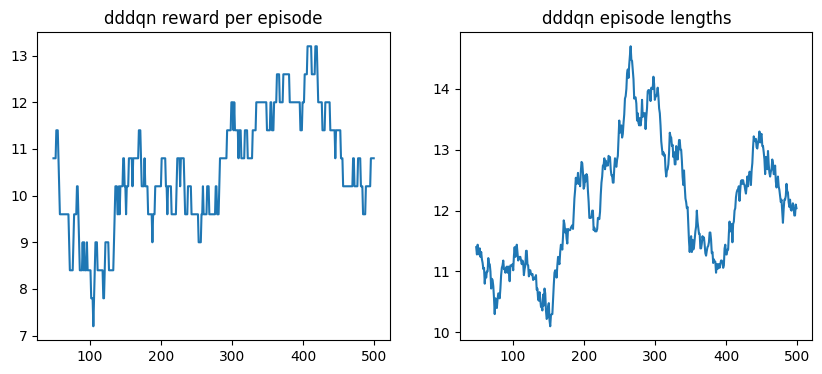

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(train_df['rewards'].rolling(50).mean())
axs[0].set_title('dddqn reward per episode')
axs[1].plot(train_df['episode_lengths'].rolling(50).mean())
axs[1].set_title('dddqn episode lengths')
